# 1. load the data

In [1]:
import os
import random

import cv2
import joblib
import numpy as np
import tqdm
from matplotlib import pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Lasso
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR, SVC
from sklearn.tree import DecisionTreeClassifier

from scripts.feature_extraction.mediapiple import get_mediapipe_preds

In [2]:
data_root_dir = '../../data/data/dataset1'


def load_image_paths_and_labels(data_root_dir):
    # return the images' path
    X = []
    X_extracted_feature = []
    y = []

    def append_path(dir, label):
        for f in os.listdir(dir):
            sub_path = os.path.join(dir, f)
            if not os.path.isdir(sub_path):
                # might be a file
                if f.endswith('.jpg') or f.endswith('.jpeg') or f.endswith('.png'):
                    X.append(sub_path)
                    y.append(label)
                if f.endswith('.npy'):
                    X_extracted_feature.append(np.load(sub_path, allow_pickle=True))
            else:
                # nested folder
                append_path(sub_path, label)

    for label in os.listdir(data_root_dir):
        label_path = os.path.join(data_root_dir, label)
        if not os.path.isdir(label_path):
            continue

        # nested folder
        append_path(label_path, label)
    return X, X_extracted_feature, y


X, X_extracted_feature, y = load_image_paths_and_labels(data_root_dir)

In [3]:
X.__len__()

9817

In [4]:
y.__len__()

9817

# 2. load the images RGB data, also extract the csv files with hand gesture estimator

In [5]:
for hands_path in tqdm.tqdm(X):
    if os.path.basename(hands_path) + '.npy' in os.listdir(os.path.dirname(hands_path)):
        continue
    hands = get_mediapipe_preds(hands_path)
    if not hands:
        continue
    X_extracted_feature.append(hands)
    np.save(f'{hands_path}.npy', hands)

100%|██████████| 9817/9817 [00:09<00:00, 992.63it/s] 


In [6]:
shapes = [arr.shape for arr in X_extracted_feature]
unique_shapes = set(shapes)
print("Unique shapes:", unique_shapes)
count = 0
c = 0
for i in X_extracted_feature:
    if i.shape == (21, 2):
        count += 1
    else:
        c += 1
print(count, c)

Unique shapes: {(21, 2)}
9817 0


In [33]:
X_extracted_feature = np.array(X_extracted_feature)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X_extracted_feature, y, test_size=0.2, random_state=42)
X_train_flattened = X_train.reshape((X_train.shape[0], -1))
X_test_flattened = X_test.reshape((X_test.shape[0], -1))
scaler = StandardScaler()
X_train_flattened_scaled = scaler.fit_transform(X_train_flattened)
X_test_flattened_scaled = scaler.transform(X_test_flattened)

mapper = {label: idx for idx, label in enumerate(np.unique(y_train))}
y_train_int = np.array([mapper[k] for k in y_train])
y_test_int = np.array([mapper[k] for k in y_test])

KeyboardInterrupt: 

In [8]:
print(mapper)

{'gesture1': 0, 'gesture2': 1, 'gesture3': 2, 'gesture4': 3, 'gesture5': 4, 'gesture6': 5, 'gesture7': 6, 'gesture8': 7}


# 3. train a classifier
## 3.1 random forest

In [9]:
random_forest_clf = RandomForestClassifier(n_estimators=100)

random_forest_clf.fit(X_train_flattened, y_train)

RandomForestClassifier()

In [10]:

y_pred = random_forest_clf.predict(X_test_flattened)

print('Classification report for classifier %s:\n', classification_report(y_test, y_pred))
print('Confusion matrix:\n', confusion_matrix(y_test, y_pred))

Classification report for classifier %s:
               precision    recall  f1-score   support

    gesture1       1.00      1.00      1.00       393
    gesture2       1.00      1.00      1.00       334
    gesture3       0.99      1.00      1.00       352
    gesture4       1.00      1.00      1.00        41
    gesture5       1.00      1.00      1.00        53
    gesture6       1.00      1.00      1.00       382
    gesture7       1.00      1.00      1.00        94
    gesture8       1.00      1.00      1.00       315

    accuracy                           1.00      1964
   macro avg       1.00      1.00      1.00      1964
weighted avg       1.00      1.00      1.00      1964

Confusion matrix:
 [[392   0   1   0   0   0   0   0]
 [  0 333   1   0   0   0   0   0]
 [  0   0 352   0   0   0   0   0]
 [  0   0   0  41   0   0   0   0]
 [  0   0   0   0  53   0   0   0]
 [  0   0   0   0   0 382   0   0]
 [  0   0   0   0   0   0  94   0]
 [  0   0   0   0   0   0   0 315]]


In [11]:
joblib.dump(random_forest_clf, "random_forest_clf.pkl")

['random_forest_clf.pkl']

## 3.2 Linear models
Since the decision boundary is in a linear feature space
This part will include:
1. Logistic regression
2. Ridge classifier
3. Lasso classifier

## 3.3 SVMs
1. linear svm
2. kernel svm

## 3.4 Tree based
1. Decision tree
2. Random forest

## 3.5 Probabilistic based
1. Naive based models
2. LDA

## 3.6 Instance based
1. KNN

## 3.7 Neural network
1. MLP

In [12]:
# linear models
# logistic regression
logistic_regression = LogisticRegression(max_iter=int(1e6))
logistic_regression.fit(X_train_flattened, y_train_int)

y_pred_logistic = logistic_regression.predict(X_test_flattened)
mse_logistic = mean_squared_error(y_test_int, y_pred_logistic)
r2_logistic = r2_score(y_test_int, y_pred_logistic)
print('Mean squared error:', mse_logistic)
print('R^2:', r2_logistic)
print('Classification report for classifier %s:\n', classification_report(y_test_int, y_pred_logistic))
print('Confusion matrix:\n', confusion_matrix(y_test_int, y_pred_logistic))

Mean squared error: 0.0005091649694501018
R^2: 0.9999211292112343
Classification report for classifier %s:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       393
           1       1.00      1.00      1.00       334
           2       1.00      1.00      1.00       352
           3       1.00      1.00      1.00        41
           4       0.98      1.00      0.99        53
           5       1.00      1.00      1.00       382
           6       1.00      1.00      1.00        94
           7       1.00      1.00      1.00       315

    accuracy                           1.00      1964
   macro avg       1.00      1.00      1.00      1964
weighted avg       1.00      1.00      1.00      1964

Confusion matrix:
 [[393   0   0   0   0   0   0   0]
 [  0 334   0   0   0   0   0   0]
 [  0   0 352   0   0   0   0   0]
 [  0   0   0  41   0   0   0   0]
 [  0   0   0   0  53   0   0   0]
 [  0   0   0   0   1 381   0   0]
 [  0   0   

In [13]:
joblib.dump(logistic_regression, "logistic_regression.pkl")

['logistic_regression.pkl']

In [14]:
# ridge classifier
ridge_classifier = RidgeClassifier()
ridge_classifier.fit(X_train_flattened, y_train_int)

y_pred_ridge = ridge_classifier.predict(X_test_flattened)
mse_ridge = mean_squared_error(y_test_int, y_pred_ridge)
r2_ridge = r2_score(y_test_int, y_pred_ridge)
print('Mean squared error:', mse_ridge)
print('R^2:', r2_ridge)
print('Classification report for classifier %s:\n', classification_report(y_test_int, y_pred_ridge))
print('Confusion matrix:\n', confusion_matrix(y_test_int, y_pred_ridge))

Mean squared error: 0.5193482688391039
R^2: 0.9195517954589701
Classification report for classifier %s:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99       393
           1       1.00      0.94      0.97       334
           2       0.99      0.99      0.99       352
           3       1.00      0.68      0.81        41
           4       0.98      1.00      0.99        53
           5       0.97      0.99      0.98       382
           6       0.99      1.00      0.99        94
           7       0.92      1.00      0.96       315

    accuracy                           0.98      1964
   macro avg       0.98      0.95      0.96      1964
weighted avg       0.98      0.98      0.98      1964

Confusion matrix:
 [[387   1   0   0   0   0   1   4]
 [  4 313   0   0   0   0   0  17]
 [  0   0 350   0   0   1   0   1]
 [  0   0   0  28   0   9   0   4]
 [  0   0   0   0  53   0   0   0]
 [  0   0   4   0   1 377   0   0]
 [  0   0   0  

In [15]:
joblib.dump(ridge_classifier, "ridge_classifier.pkl")

['ridge_classifier.pkl']

In [16]:
# lasso classifier
lasso_classifier = LogisticRegression(max_iter=int(1e6), penalty='l1', solver='saga', multi_class='auto')

lasso_classifier.fit(X_train_flattened_scaled, y_train_int)
y_pred_lasso = lasso_classifier.predict(X_test_flattened_scaled)

mse_lasso = mean_squared_error(y_test_int, y_pred_lasso)
r2_lasso = r2_score(y_test_int, y_pred_lasso)
print('Mean squared error:', mse_lasso)
print('R^2:', r2_lasso)
print('Classification report for classifier %s:\n', classification_report(y_test_int, y_pred_lasso))
print('Confusion matrix:\n', confusion_matrix(y_test_int, y_pred_lasso))

C:\Users\50601\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Mean squared error: 0.06313645621181263
R^2: 0.9902200221930513
Classification report for classifier %s:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       393
           1       1.00      0.99      0.99       334
           2       1.00      0.99      1.00       352
           3       1.00      1.00      1.00        41
           4       0.98      1.00      0.99        53
           5       1.00      1.00      1.00       382
           6       0.98      1.00      0.99        94
           7       0.99      1.00      1.00       315

    accuracy                           1.00      1964
   macro avg       0.99      1.00      1.00      1964
weighted avg       1.00      1.00      1.00      1964

Confusion matrix:
 [[393   0   0   0   0   0   0   0]
 [  1 330   0   0   0   0   1   2]
 [  0   0 350   0   0   1   1   0]
 [  0   0   0  41   0   0   0   0]
 [  0   0   0   0  53   0   0   0]
 [  0   0   0   0   1 381   0   0]
 [  0   0   0 

In [17]:
joblib.dump(lasso_classifier, "lasso_classifier.pkl")

['lasso_classifier.pkl']

In [18]:
# SVMs
# linear svm
svc_linear = SVC(kernel='linear', C=10.0, gamma=0.01)
svc_linear.fit(X_train_flattened_scaled, y_train_int)

y_pred_svc_linear = svc_linear.predict(X_test_flattened_scaled)

mse_linear_svm = mean_squared_error(y_test_int, y_pred_svc_linear)
r2_linear_svm = r2_score(y_test_int, y_pred_svc_linear)
print('Mean squared error:', mse_linear_svm)
print('R^2:', r2_linear_svm)
print('Classification report for classifier %s:\n', classification_report(y_test_int, y_pred_svc_linear))
print('Confusion matrix:\n', confusion_matrix(y_test_int, y_pred_svc_linear))

Mean squared error: 0.0010183299389002036
R^2: 0.9998422584224685
Classification report for classifier %s:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       393
           1       1.00      1.00      1.00       334
           2       1.00      1.00      1.00       352
           3       1.00      1.00      1.00        41
           4       0.98      1.00      0.99        53
           5       1.00      1.00      1.00       382
           6       1.00      0.99      0.99        94
           7       1.00      1.00      1.00       315

    accuracy                           1.00      1964
   macro avg       1.00      1.00      1.00      1964
weighted avg       1.00      1.00      1.00      1964

Confusion matrix:
 [[393   0   0   0   0   0   0   0]
 [  0 334   0   0   0   0   0   0]
 [  0   0 352   0   0   0   0   0]
 [  0   0   0  41   0   0   0   0]
 [  0   0   0   0  53   0   0   0]
 [  0   0   0   0   1 381   0   0]
 [  0   0   

In [19]:
joblib.dump(svc_linear, "svc_linear.pkl")

['svc_linear.pkl']

In [20]:
# kernel svm
svm_rbf = SVC(kernel='rbf', C=10.0, gamma=0.01)
svm_rbf.fit(X_train_flattened_scaled, y_train_int)
y_pred_svm_rbf = svm_rbf.predict(X_test_flattened_scaled)

mse_rbf = mean_squared_error(y_test_int, y_pred_svm_rbf)
r2_rbf = r2_score(y_test_int, y_pred_svm_rbf)
print('Mean squared error:', mse_rbf)
print('R^2:', r2_rbf)
print('Classification report for classifier %s:\n', classification_report(y_test_int, y_pred_svm_rbf))
print('Confusion matrix:\n', confusion_matrix(y_test_int, y_pred_svm_rbf))

Mean squared error: 0.0010183299389002036
R^2: 0.9998422584224685
Classification report for classifier %s:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       393
           1       1.00      1.00      1.00       334
           2       1.00      1.00      1.00       352
           3       1.00      1.00      1.00        41
           4       0.98      1.00      0.99        53
           5       1.00      1.00      1.00       382
           6       1.00      0.99      0.99        94
           7       1.00      1.00      1.00       315

    accuracy                           1.00      1964
   macro avg       1.00      1.00      1.00      1964
weighted avg       1.00      1.00      1.00      1964

Confusion matrix:
 [[393   0   0   0   0   0   0   0]
 [  0 334   0   0   0   0   0   0]
 [  0   0 352   0   0   0   0   0]
 [  0   0   0  41   0   0   0   0]
 [  0   0   0   0  53   0   0   0]
 [  0   0   0   0   1 381   0   0]
 [  0   0   

In [21]:
joblib.dump(svm_rbf, "svm_rbf.pkl")

['svm_rbf.pkl']

In [22]:
# tree based
# decision tree
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train_flattened, y_train_int)
y_pred_decision_tree = decision_tree.predict(X_test_flattened)
mse_decision_tree = mean_squared_error(y_test_int, y_pred_decision_tree)
r2_decision_tree = r2_score(y_test_int, y_pred_decision_tree)
print('Mean squared error:', mse_decision_tree)
print('R^2:', r2_decision_tree)
print('Classification report for classifier %s:\n', classification_report(y_test_int, y_pred_decision_tree))
print('Confusion matrix:\n', confusion_matrix(y_test_int, y_pred_decision_tree))

Mean squared error: 0.1909368635437882
R^2: 0.9704234542128567
Classification report for classifier %s:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98       393
           1       0.97      0.99      0.98       334
           2       0.99      0.99      0.99       352
           3       0.98      1.00      0.99        41
           4       0.93      0.98      0.95        53
           5       1.00      0.99      1.00       382
           6       1.00      0.99      0.99        94
           7       0.98      0.98      0.98       315

    accuracy                           0.99      1964
   macro avg       0.98      0.99      0.98      1964
weighted avg       0.99      0.99      0.99      1964

Confusion matrix:
 [[383   8   1   0   0   0   0   1]
 [  2 329   1   0   0   0   0   2]
 [  0   1 349   0   1   0   0   1]
 [  0   0   0  41   0   0   0   0]
 [  0   0   0   1  52   0   0   0]
 [  0   0   0   0   2 380   0   0]
 [  0   0   0  

In [23]:
joblib.dump(decision_tree, "decision_tree.pkl")

['decision_tree.pkl']

In [24]:
# probabilistic based
# naive based
naive_bayes = GaussianNB()
naive_bayes.fit(X_train_flattened, y_train_int)
y_pred_naive = naive_bayes.predict(X_test_flattened)
mse_naive = mean_squared_error(y_test_int, y_pred_naive)
r2_naive = r2_score(y_test_int, y_pred_naive)
print('Mean squared error:', mse_naive)
print('R^2:', r2_naive)
print('Classification report for classifier %s:\n', classification_report(y_test_int, y_pred_naive))
print('Confusion matrix:\n', confusion_matrix(y_test_int, y_pred_naive))

Mean squared error: 6.194501018329939
R^2: 0.04045798387630495
Classification report for classifier %s:
               precision    recall  f1-score   support

           0       0.53      0.57      0.55       393
           1       0.47      0.66      0.55       334
           2       0.54      0.28      0.37       352
           3       0.28      0.49      0.35        41
           4       0.34      0.94      0.50        53
           5       0.76      0.62      0.68       382
           6       0.38      0.76      0.50        94
           7       0.52      0.28      0.36       315

    accuracy                           0.51      1964
   macro avg       0.48      0.57      0.48      1964
weighted avg       0.55      0.51      0.50      1964

Confusion matrix:
 [[224  76  15   3   0  26  10  39]
 [ 62 219  19   0   0  10  13  11]
 [ 54 143  98   8   2  18   0  29]
 [  0   0   0  20  12   3   6   0]
 [  0   0   0   0  50   0   3   0]
 [  9   0   0  32  63 238  40   0]
 [  0   0   0  

In [25]:
joblib.dump(naive_bayes, "naive_bayes.pkl")

['naive_bayes.pkl']

In [26]:
# Linear discriminant Analysis
LDA = LinearDiscriminantAnalysis()
LDA.fit(X_train_flattened, y_train_int)
y_pred_LDA = LDA.predict(X_test_flattened)
mse_LDA = mean_squared_error(y_test_int, y_pred_LDA)
r2_LDA = r2_score(y_test_int, y_pred_LDA)
print('Mean squared error:', mse_LDA)
print('R^2:', r2_LDA)
print('Classification report for classifier %s:\n', classification_report(y_test_int, y_pred_LDA))
print('Confusion matrix:\n', confusion_matrix(y_test_int, y_pred_LDA))

Mean squared error: 0.34470468431771895
R^2: 0.9466044760056106
Classification report for classifier %s:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99       393
           1       1.00      0.97      0.98       334
           2       0.99      0.99      0.99       352
           3       1.00      0.98      0.99        41
           4       0.98      1.00      0.99        53
           5       0.99      0.99      0.99       382
           6       0.99      1.00      0.99        94
           7       0.95      1.00      0.98       315

    accuracy                           0.99      1964
   macro avg       0.99      0.99      0.99      1964
weighted avg       0.99      0.99      0.99      1964

Confusion matrix:
 [[387   1   0   0   0   0   1   4]
 [  1 323   0   0   0   0   0  10]
 [  2   0 348   0   0   1   0   1]
 [  0   0   0  40   0   1   0   0]
 [  0   0   0   0  53   0   0   0]
 [  0   0   4   0   1 377   0   0]
 [  0   0   0 

In [27]:
joblib.dump(LDA, "LDA.pkl")

['LDA.pkl']

In [28]:
# instance based
# knn
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_flattened, y_train_int)
y_pred_knn = knn_model.predict(X_test_flattened)
mse_knn = mean_squared_error(y_test_int, y_pred_knn)
r2_knn = r2_score(y_test_int, y_pred_knn)
print('Mean squared error:', mse_knn)
print('R^2:', r2_knn)
print('Classification report for classifier %s:\n', classification_report(y_test_int, y_pred_knn))
print('Confusion matrix:\n', confusion_matrix(y_test_int, y_pred_knn))

Mean squared error: 0.11965376782077393
R^2: 0.9814653646400568
Classification report for classifier %s:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99       393
           1       1.00      1.00      1.00       334
           2       1.00      0.99      0.99       352
           3       1.00      1.00      1.00        41
           4       0.98      1.00      0.99        53
           5       0.99      1.00      0.99       382
           6       1.00      1.00      1.00        94
           7       0.99      1.00      0.99       315

    accuracy                           0.99      1964
   macro avg       0.99      1.00      1.00      1964
weighted avg       0.99      0.99      0.99      1964

Confusion matrix:
 [[389   1   0   0   0   0   0   3]
 [  0 333   1   0   0   0   0   0]
 [  0   0 348   0   0   4   0   0]
 [  0   0   0  41   0   0   0   0]
 [  0   0   0   0  53   0   0   0]
 [  0   0   0   0   1 381   0   0]
 [  0   0   0 

In [29]:
joblib.dump(knn_model, "knn_model.pkl")

['knn_model.pkl']

In [30]:
# neural network
# MLP
mlp = MLPClassifier()
mlp.fit(X_train_flattened, y_train_int)
y_pred_mlp = mlp.predict(X_test_flattened)
mse_mlp = mean_squared_error(y_test_int, y_pred_mlp)
r2_mlp = r2_score(y_test_int, y_pred_mlp)
print('Mean squared error:', mse_mlp)
print('R^2:', r2_mlp)
print('Classification report for classifier %s:\n', classification_report(y_test_int, y_pred_mlp))
print('Confusion matrix:\n', confusion_matrix(y_test_int, y_pred_mlp))

Mean squared error: 2.5865580448065173
R^2: 0.5993363930701652
Classification report for classifier %s:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97       393
           1       1.00      0.65      0.79       334
           2       0.81      0.99      0.89       352
           3       1.00      0.95      0.97        41
           4       0.98      0.75      0.85        53
           5       1.00      0.85      0.92       382
           6       0.00      0.00      0.00        94
           7       0.61      0.99      0.76       315

    accuracy                           0.85      1964
   macro avg       0.79      0.77      0.77      1964
weighted avg       0.85      0.85      0.83      1964

Confusion matrix:
 [[388   0   1   0   0   0   0   4]
 [  8 218   7   0   0   0   0 101]
 [  0   0 348   0   0   0   0   4]
 [  0   0   2  39   0   0   0   0]
 [  0   0  13   0  40   0   0   0]
 [  0   0  56   0   1 325   0   0]
 [  8   0   0  

C:\Users\50601\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\50601\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\50601\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

In [31]:
joblib.dump(mlp, "mlp.pkl")

['mlp.pkl']

# visualize a random one of them

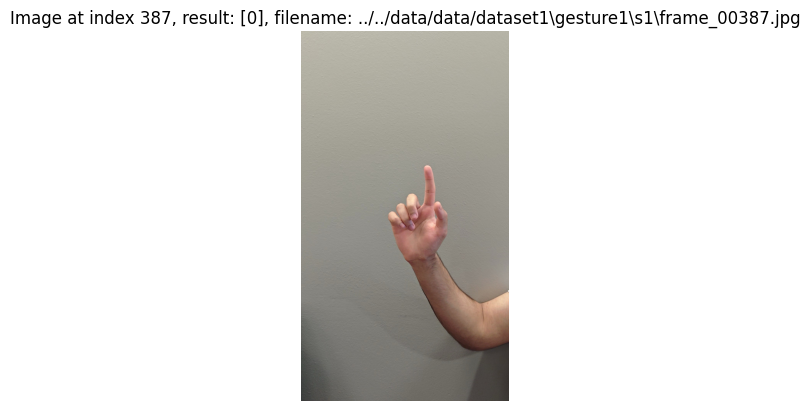

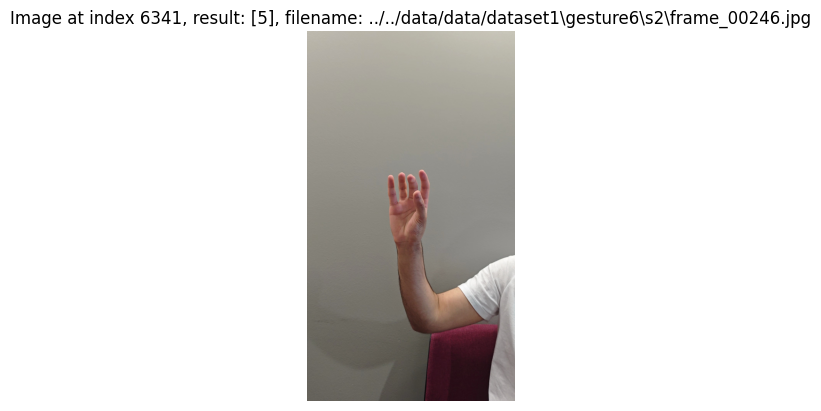

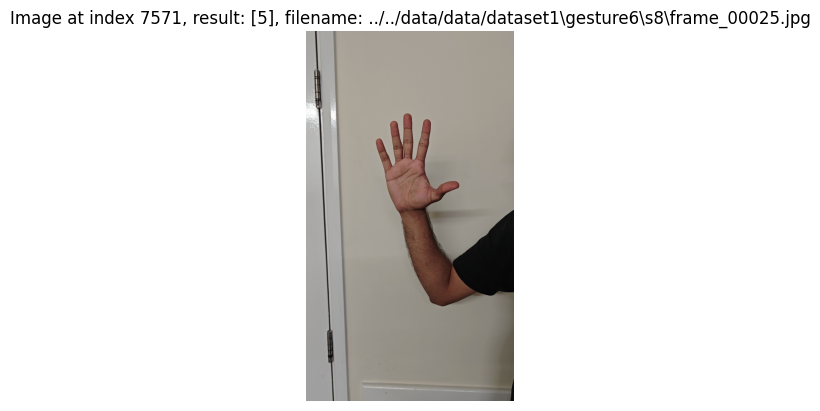

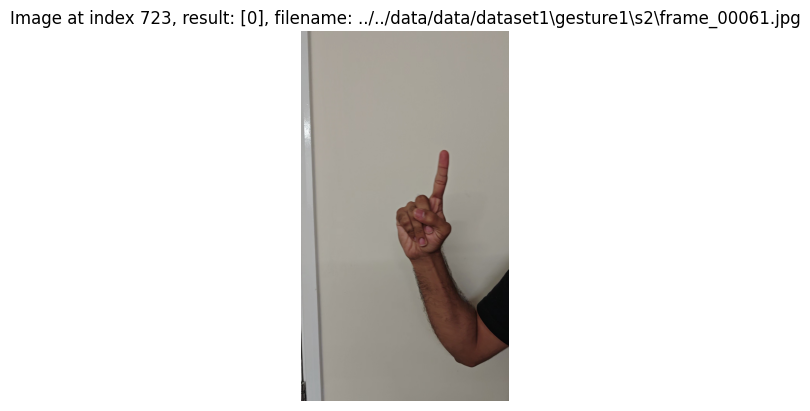

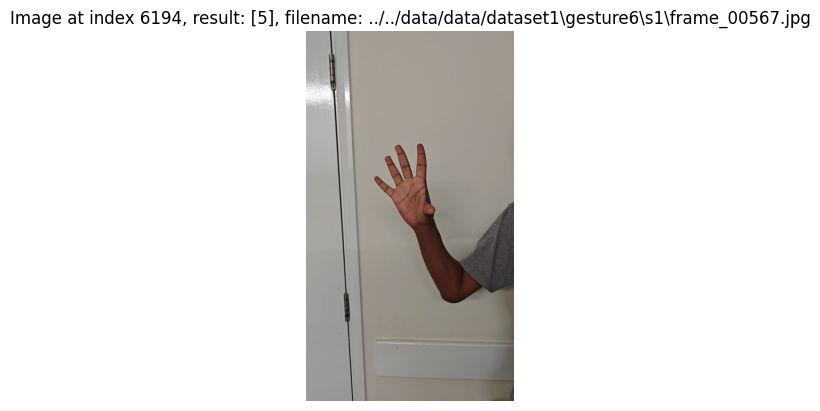

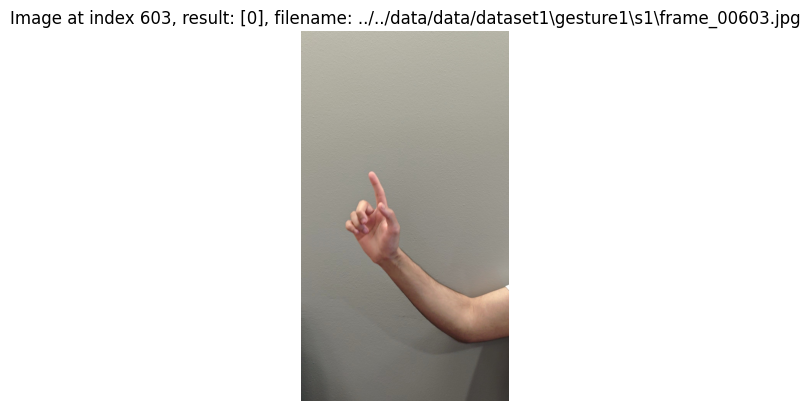

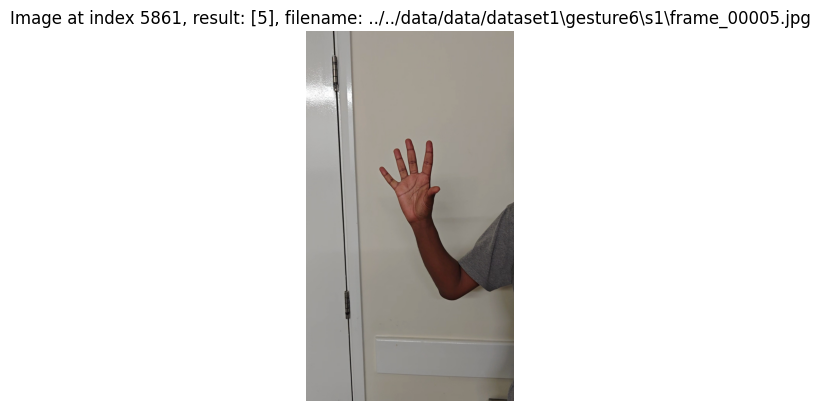

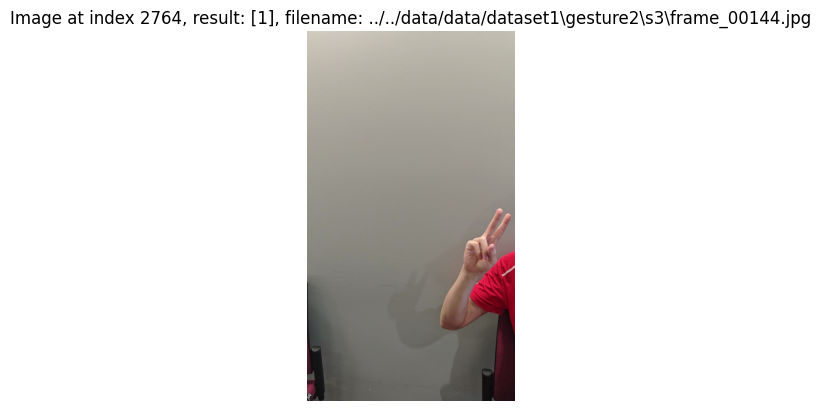

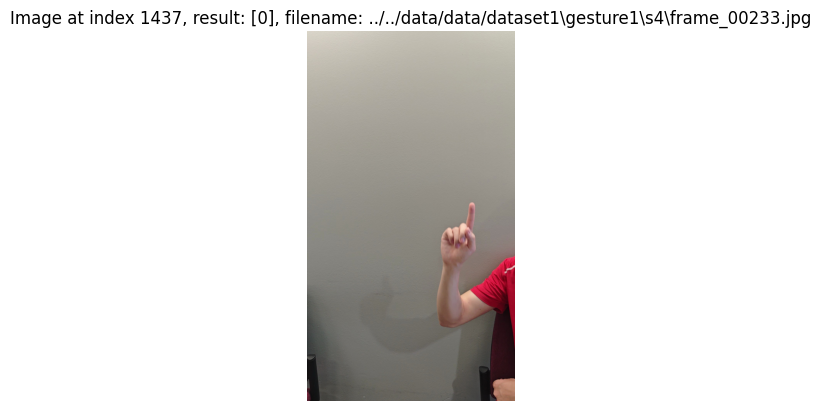

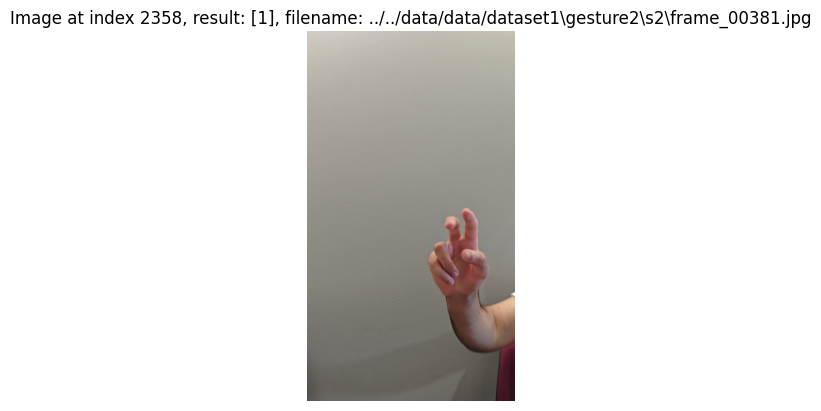

In [32]:
def random_visualize(model):
    # Randomly pick one index
    idx = random.randint(0, len(X) - 1)
    img = cv2.imread(X[idx])
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    features = np.array([np.load(X[idx] + '.npy')])
    input_feature = features.reshape((features.shape[0], -1))
    res = model.predict(input_feature)

    if img_rgb.mean() < 50:  # Adjust threshold as needed
        img_rgb = 255 - img_rgb

    plt.imshow(img_rgb)
    plt.title(f"Image at index {idx}, result: {res}, filename: {X[idx]}")
    plt.axis('off')
    plt.show()


for _ in range(10):
    random_visualize(knn_model)